# Variations of the Trapping theorem -- different Lyapunov functions
This example will be used to demonstrate that both the energy and enstrophy can be used as Lyapunov functions for promoting local and global stability with the trapping theorems used for quadratically nonlinear systems of ODEs.

We will demonstrate this using a canonical 2D fluid flow (2D so that the enstrophy is conserved).
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.
The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. In general, the totally symmetric structure in the quadratic coefficients $Q_{ijk}$ is weakly *broken* in models for the von Karman street, but it can be enforced to hold exactly. 

This is precisely what is done in Schlegel and Noack (2015), and in this perfectly-skew-symmetric case, the global stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Indeed, we do similarly for data-driven models obtained with the SINDy method in the trapping_sindy_paper_examples.ipynb Jupyter notebook corresponding to the Trapping SINDy paper (https://journals.aps.org/prfluids/abstract/10.1103/PhysRevFluids.6.094401).

### This notebook will show that both the energy and enstrophy can be used with the trapping theorem to promote global stability.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pymech.neksuite as nek
from trapping_utils import *

#### We have pre-loaded some useful functions, and now we can load in the von Karman DNS data. For simplicity (and speed of the code), we will limit ourselves to 5D models, using the first 4 POD modes + the shift mode.

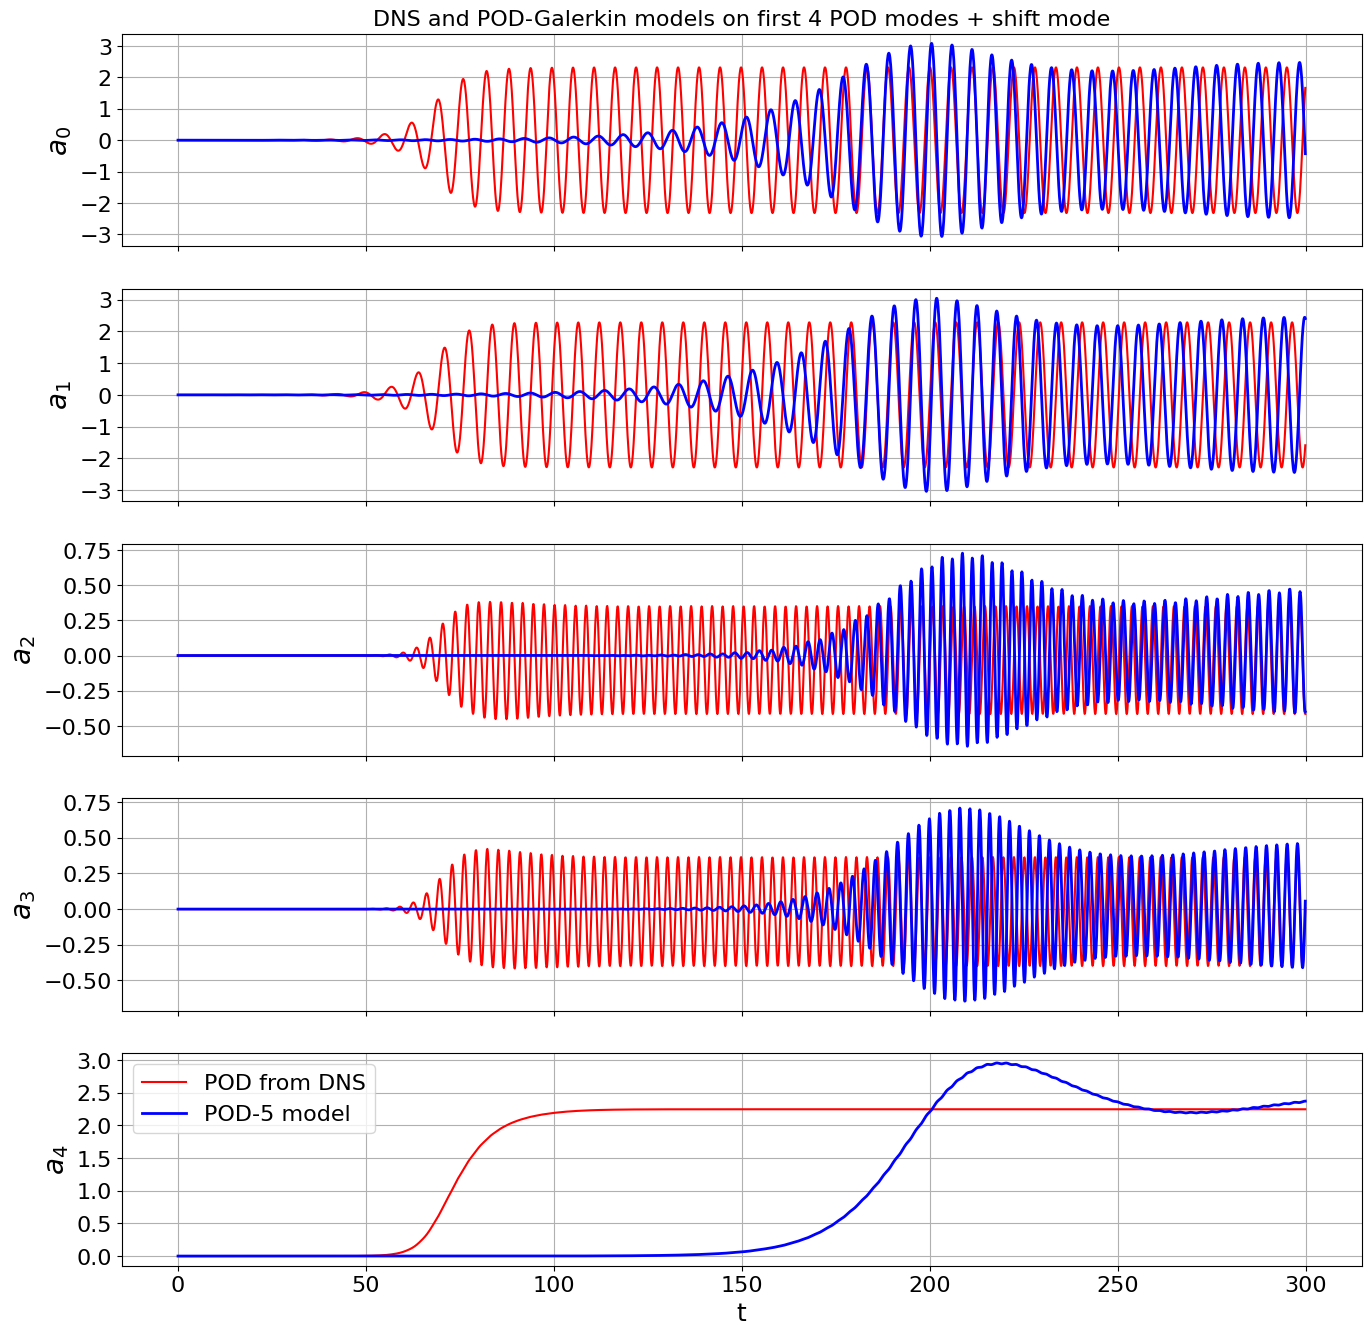

In [2]:
# define parameters and load in POD modes obtained from DNS
a = np.loadtxt('../data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 5
a_temp = a[:, 1:r]
a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
a = a_temp

# optionally reduce the resolution slightly for more algorithm speed later
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]

# define the POD-Galerkin models from Noack (2003)
galerkin9 = sio.loadmat('../data/vonKarman_pod/galerkin9.mat')

# Build two Galerkin models, one in which the nonlinearity is as 
# calculated, and the other enforced to be exactly skew-symmetric.
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q_ep'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0
model9 = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q'])
model9_ep = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q_ep'])

# Generate initial condition from unstable eigenvectors
# lamb, Phi = np.linalg.eig(galerkin9['L'])
# idx = np.argsort(-np.real(lamb))
# lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(5)
a0[0] = 1e-3

# get the 5D POD-Galerkin coefficients
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5 = {}
galerkin5['L'] = galerkin9['L'][inds5]
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5['Q'] = galerkin9['Q'][inds5]
galerkin5['Q_ep'] = galerkin9['Q_ep'][inds5]
model5 = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])

# make the 5D POD-Galerkin model trajectories
t_span = (t[0], t[-1])
a_galerkin5 = solve_ivp(model5, t_span, a0, t_eval=t, 
                        **integrator_keywords).y.T
adot_galerkin5 = np.gradient(a_galerkin5, axis=0) / (t[1] - t[0])

# plot the first 4 POD modes + the shift mode
mode_numbers = range(10)
plt.figure(figsize=(16, 16))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    if i == 0:
        plt.title('DNS and POD-Galerkin models on first 4 POD modes + shift mode', 
                  fontsize=16)
    plt.plot(t, a[:, mode_numbers[i]], 'r', label='POD from DNS')
    plt.plot(t, a_galerkin5[:, mode_numbers[i]], 'b', linewidth=2, label='POD-5 model')
    ax = plt.gca()
    plt.ylabel(r'$a_{' + str(mode_numbers[i]) + '}$', fontsize=20)
    plt.grid(True)
    if i == r - 1:
        plt.xlabel('t', fontsize=18)
        plt.legend(loc='upper left', fontsize=16)
    else:
        ax.set_xticklabels([])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

### Compute the velocity, vorticity, and enstrophy
The first thing we will do is promote globally stable models via the trapping SINDy algorithm, as in the trapping_sindy_paper_examples.ipynb notebook. We can actually do this by calculating a stability matrix $\mathbf{A}^S$ with *either* the energy or the enstrophy (or any other positive definite, quadratic quantity that plays an important role in the dynamics). So we begin by constructing globally stable trapping models of the von Karman street in these two ways.

First, we load in the data and compute the energy and enstrophy.

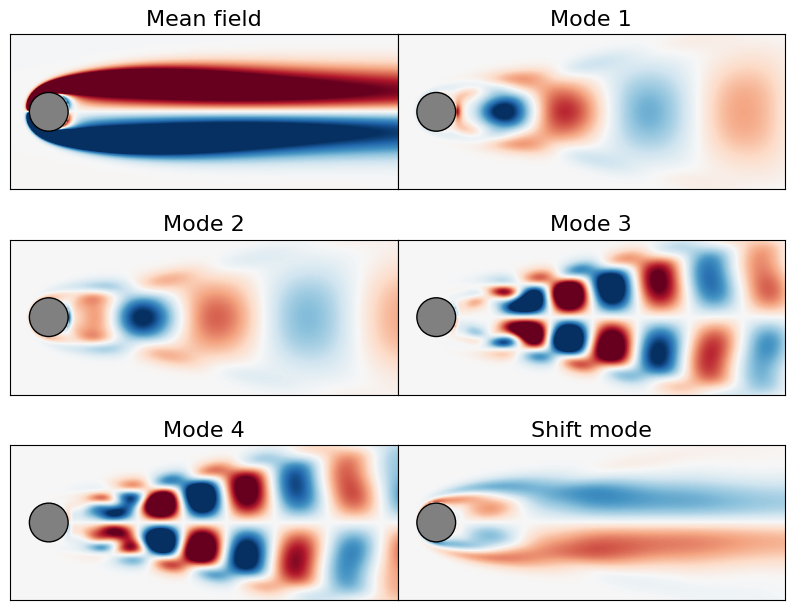

In [3]:
# path to POD mode files
field_path = '../data/vonKarman_pod/cyl0.snapshot'  
mode_path = '../data/vonKarman_pod/pod_modes/'  

# Read limit cycle flow field for grid points
field = nek.readnek(field_path)
n = nel * nGLL ** 2

# define cell values needed for the vorticity interpolation
Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)

# plot mean + leading POD modes
clim = [-1, 1]
file_order = [1, 2, 3, 4, 5, 10]
file_labels = ['Mean field', 
               'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4',
               'Shift mode']

# Plot the vorticity fields as we load them in
fig = plt.figure(figsize=(10, 8))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, hspace=0.0, wspace=0.0)
u_list = []
v_list = []
vorticities = []
vorticities_flat = []
for i in range(len(file_order)):
    plt.subplot(spec[i])
    u, v = get_velocity(mode_path + filename(file_order[i]))
    u_list.append(u)
    v_list.append(v)
    vort = interp( get_vorticity(mode_path + filename(file_order[i])), Cx, Cy)
    vorticities.append(np.reshape(vort, [nx, ny], order='F').T)
    vorticities_flat.append(get_vorticity(mode_path + filename(file_order[i])))
    
    plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, 
               label=file_labels[i])
    plt.xlim([-1, 9])
    plt.ylim([-2, 2])
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(file_labels[i], fontsize=16)

plt.show()

We have loaded in the vorticity fields of each POD mode, now need to calculate the  energy and the enstrophy.

In [4]:
mass_matrix = np.loadtxt('../data/vonKarman_pod/pod_modes/mass_matrix.dat')
ip1 = lambda a, b: np.dot(mass_matrix * a, b)
ip2 = lambda a, b, c, d: np.dot(a * mass_matrix, c) + np.dot(b * mass_matrix, d)
energy_integrals = np.zeros((6, 6))
enstrophy_integrals = np.zeros((6, 6))
for i, wi in enumerate(vorticities_flat):
    for j, wj in enumerate(vorticities_flat):
        if i == 0:
            enstrophy_integrals[i, j] = ip2(u_list[i], v_list[i], wj, wj)
        else:
            enstrophy_integrals[i, j] = ip1(wi, wj)
        energy_integrals[i, j] = ip2(u_list[i], v_list[i], u_list[j], v_list[j])

Do some checks to make sure energy eigenvalues and enstrophy eigenvalues make sense (energy eigenvalues should be identitity because we are using the eigenbasis of energy, and enstrophy eigenvalues should be positive since enstrophy is by construction a positive definite quantity).

In [5]:
# Compute the energy eigenvalues 
P_energy = energy_integrals[1:, 1:]
eigs_energy, eigvecs_energy = np.linalg.eigh(P_energy)
print(eigs_energy)

# Compute the enstrophy eigenvalues 
P_enstrophy = enstrophy_integrals[1:, 1:]
eigs_enstrophy, eigvecs_enstrophy = np.linalg.eigh(P_enstrophy)
print(eigs_enstrophy)

# Define the linear part of the model, 
# rotated into the eigenbasis of enstrophy
L_enstrophy = np.dot(P_enstrophy, galerkin5['L'])

[1. 1. 1. 1. 1.]
[ 2.67263208  2.77593793  2.99681091 10.56822815 10.72500109]


### Check global stability of the POD-Galerkin models
Okay, so we have loaded in some DNS data from the von Karman Street and generated (analytic) 5D POD-Galerkin models for this system. The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic term $Q_{ijk}$ has no totally-symmetric part this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary when $Q_{ijk}$ does have nontrivial totally symmetric component, but in this case is not sufficient for global boundedness and we can promote local stability as in the trapping_extended.ipynb notebook.

Next we check with a simple nonlinear algorithm (simulated annealing) that our analytic models can be shown to be globally stable (there is an $\mathbf{m}$ such that $\mathbf{A}^S$ is negative definite) using both the energy or the enstrophy to construct $\mathbf{A}^S$.

In [6]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

# Search between -5000, 5000 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 5000
boundmin = -5000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

Ls_enstrophy = 0.5 * (L_enstrophy + L_enstrophy.T)
# Run simulated annealing for the enstrophy eigenbasis
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls_enstrophy, galerkin5['Q_ep'], P_enstrophy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Enstrophy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat using the energy
Ls = 0.5 * (galerkin5['L'] + galerkin5['L'].T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin5['Q_ep'], P_energy), 
                       maxiter=1000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Energy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

Enstrophy model result:
Optimal m =  [3.88091773e-01 5.06000472e-01 2.12968374e+01 8.95937228e+01
 5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.5291486743305617 

Energy model result:
Optimal m =  [ 1.35938086e-03 -2.66984031e-04  2.48080685e-01  9.68263056e-02
  2.04798736e+01]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.04388638899870734 



#### We have proven that both the models, with totally symmetric quadratic tensors, are globally stable. 
We now fix the coefficients of $\mathbf{m}$ except for the direction of the shift-mode, and scan this value to see how the largest eigenvalue of $\mathbf{A}^S$ (and corresponding trapping region radius) varies.

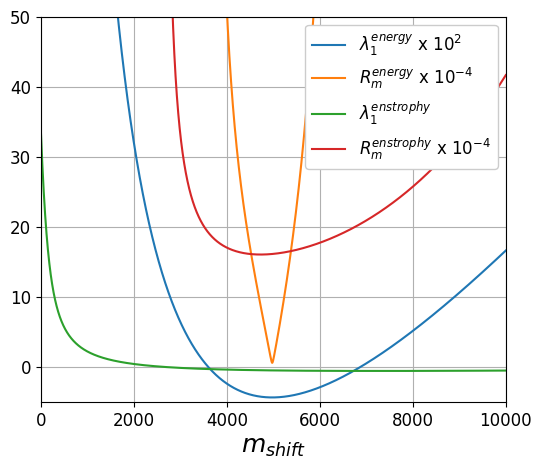

In [7]:
N = 5000
alphas = np.linspace(0, 10000, N)
m = np.zeros(r)
m[:-1] = [1.05133223e-01, 3.65030827e-02, 5.29009012e+01, 3.14215584e+01]
m_enstrophy = np.zeros(r)
m_enstrophy[:-1] = [3.87083390e-01, 5.23018605e-01, 2.13126168e+01, 8.95957413e+01]

obj_energy = np.zeros(N)
obj_enstrophy = np.zeros(N)
Rm_energy = np.zeros(N)
Rm_enstrophy = np.zeros(N)

# Extract maximum and minimum eigenvalues, 
# and compute radius of the trapping region
max_eig_energy = np.sort(eigs_energy)[-1]
max_eig_enstrophy = np.sort(eigs_enstrophy)[-1]

for i, alpha in enumerate(alphas):
    m[-1] = alpha
    m_enstrophy[-1] = alpha
    obj_energy[i] = obj_function(m, Ls, 
                                 galerkin5['Q_ep'], P_energy)
    obj_enstrophy[i] = obj_function(m_enstrophy, Ls_enstrophy, 
                                    galerkin5['Q_ep'], P_enstrophy)
    d_energy = np.dot(galerkin5['L'], m) + np.dot(
        np.tensordot(galerkin5['Q_ep'], m, axes=([2], [0])), m)
    d_enstrophy = np.dot(L_enstrophy, m_enstrophy) + np.dot(
        np.tensordot(galerkin5['Q_ep'], m_enstrophy, 
                     axes=([2], [0])), m_enstrophy)
    Rm_energy[i] = np.linalg.norm(d_energy) / np.abs(obj_energy[i])
    Rm_enstrophy[i] = np.linalg.norm(d_enstrophy) / np.abs(obj_enstrophy[i])

plt.figure(figsize=(6, 5))
plt.plot(alphas, obj_energy * 1e2, label='$\lambda_1^{energy}$ x $10^2$')
plt.plot(alphas[obj_energy < 0], Rm_energy[obj_energy < 0] / 1.0e4, 
         label='$R_m^{energy}$ x $10^{-4}$')
plt.plot(alphas, obj_enstrophy, label='$\lambda_1^{enstrophy}$')
plt.plot(alphas[obj_enstrophy < 0], Rm_enstrophy[obj_enstrophy < 0] / 1.0e4, 
         label='$R_m^{enstrophy}$ x $10^{-4}$')
plt.legend(fontsize=12, loc='upper right', framealpha=1.0)
plt.ylim(-5, 50)
plt.xlim(0, 10000)
plt.grid(True)
plt.xlabel(r'$m_{shift}$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [40]:
galerkin_ep = (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0
print(np.max(abs(galerkin_ep)))
gQ_enstrophy = enstrophy_integrals[1:, 1:] @ gQ  # [inds5]
galerkin_ep = (gQ_enstrophy + np.transpose(gQ_enstrophy, [1, 0, 2]) + np.transpose(
    gQ_enstrophy, [2, 1, 0]) + np.transpose(
    gQ_enstrophy, [0, 2, 1]) + np.transpose(
    gQ_enstrophy, [2, 0, 1]) + np.transpose(
    gQ_enstrophy, [1, 2, 0])) / 6.0
print(np.max(abs(galerkin_ep)))

0.0003931843531373586
0.04179936940675453


### Data-driven 5D models for the von Karman street using Trapping SINDy
We have investigated a number of 5D (analytic) POD-Galerkin models and shown that the analytic, constrained models are globally stable. Now we show that trapping SINDy can be used with the energy or enstrophy to build data-driven models that are also globally stable. 

In [8]:
max_iter = 5000
eta = 1.0e2
threshold = 0
alpha_m = 9e-1 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix[:, r:],
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library_no_bias,
)
model.fit(a, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
energy_model = model
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Maximum deviation from the constraints = ', Q_sum)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.607e-01 ... 2.862e-03 ... 0.00e+00 ... 6.73e-22 ... 1.22e-43 ... 8.64e-01
  500 ... 8.650e-01 ... 1.437e-05 ... 0.00e+00 ... 7.70e-22 ... 5.66e-42 ... 8.65e-01
 1000 ... 8.746e-01 ... 1.303e-06 ... 0.00e+00 ... 9.31e-22 ... 1.87e-42 ... 8.75e-01
 1500 ... 8.778e-01 ... 2.839e-07 ... 0.00e+00 ... 9.78e-22 ... 4.92e-42 ... 8.78e-01
 2000 ... 8.791e-01 ... 7.074e-08 ... 0.00e+00 ... 9.97e-22 ... 3.66e-42 ... 8.79e-01
 2500 ... 8.798e-01 ... 1.853e-08 ... 0.00e+00 ... 1.01e-21 ... 7.95e-43 ... 8.80e-01
 3000 ... 8.801e-01 ... 4.967e-09 ... 0.00e+00 ... 1.01e-21 ... 9.77e-42 ... 8.80e-01
 3500 ... 8.803e-01 ... 1.347e-09 ... 0.00e+00 ... 1.01e-21 ... 9.87e-42 ... 8.80e-01
optimal m:  [-0.05858964  0.03912922 -0.4209338  -0.67187345  4.13259288]
As eigvals:  [-0.39341797 -0.270266   -0.18711847 -0.09985869 -0.09970669]
Estimate of trapping region size, Rm =  20.052557694147108
Normalized trap

The previous model finds an $\mathbf{m}$ such that $\mathbf{A}^S$ is negative definite, while also fitting the data. Now we can repeat but in the eigenbasis of enstrophy. If the enstrophy is $H = \mathbf{y}^T\mathcal{P}\mathbf{A}^S \mathbf{y}$, now we are searching for an $\mathbf{m}$ such that $\mathcal{P}\mathbf{A}^S$ is negative definite.

In [26]:
max_iter = 5000
eta = 1.0e4
threshold = 0
alpha_m = 1e-1 * eta

mod_matrix = enstrophy_integrals[1:, 1:]
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta, 
    alpha_m=alpha_m,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix[:, r:],
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    mod_matrix=mod_matrix,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library_no_bias,
)
model.fit(a, t=t)
Xi = model.coefficients().T
Lenstrophy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenstrophy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val, mod_matrix)
enstrophy_model = model
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Maximum deviation from the constraints = ', Q_sum)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.554e-01 ... 1.402e-03 ... 0.00e+00 ... 4.05e-20 ... 1.29e-20 ... 8.57e-01
  500 ... 8.578e-01 ... 4.000e-07 ... 0.00e+00 ... 4.59e-20 ... 1.61e-20 ... 8.58e-01
 1000 ... 8.590e-01 ... 4.273e-07 ... 0.00e+00 ... 4.86e-20 ... 1.71e-20 ... 8.59e-01
 1500 ... 8.606e-01 ... 5.014e-07 ... 0.00e+00 ... 5.15e-20 ... 1.82e-20 ... 8.61e-01
 2000 ... 8.625e-01 ... 5.449e-07 ... 0.00e+00 ... 5.49e-20 ... 1.97e-20 ... 8.62e-01
 2500 ... 8.649e-01 ... 5.914e-07 ... 0.00e+00 ... 5.88e-20 ... 2.14e-20 ... 8.65e-01
 3000 ... 8.680e-01 ... 7.081e-07 ... 0.00e+00 ... 6.33e-20 ... 2.35e-20 ... 8.68e-01
 3500 ... 8.719e-01 ... 9.873e-07 ... 0.00e+00 ... 6.88e-20 ... 2.60e-20 ... 8.72e-01
 4000 ... 8.772e-01 ... 1.544e-06 ... 0.00e+00 ... 7.54e-20 ... 2.92e-20 ... 8.77e-01
 4500 ... 8.842e-01 ... 2.543e-06 ... 0.00e+00 ... 8.36e-20 ... 3.32e-20 ... 8.84e-01
optimal m:  [-0.58400047 -0.02483438 -0.34353606 -0

/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:882: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  warnings.warn(


Enstrophy model was successful!
#### We have built two data-driven models, one using the energy as a Lyapunov function for trapping SINDy, and the other using the enstrophy. Now we compare the distribution of coefficients in each model.

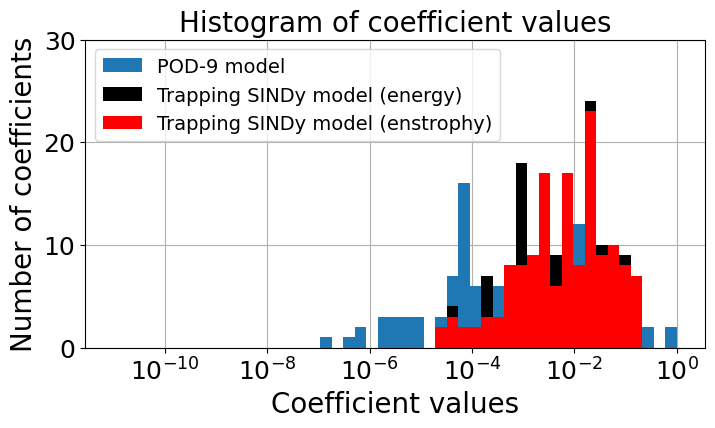

In [10]:
make_bar(galerkin5, Lenergy, Qenergy, Lenstrophy, Qenstrophy)

### Compare the models
Below, we compare the 5D POD-Galerkin with trapping SINDy models obtained by considering the energy or by the enstrophy. Both trapping models outperform the POD-Galerkin model.

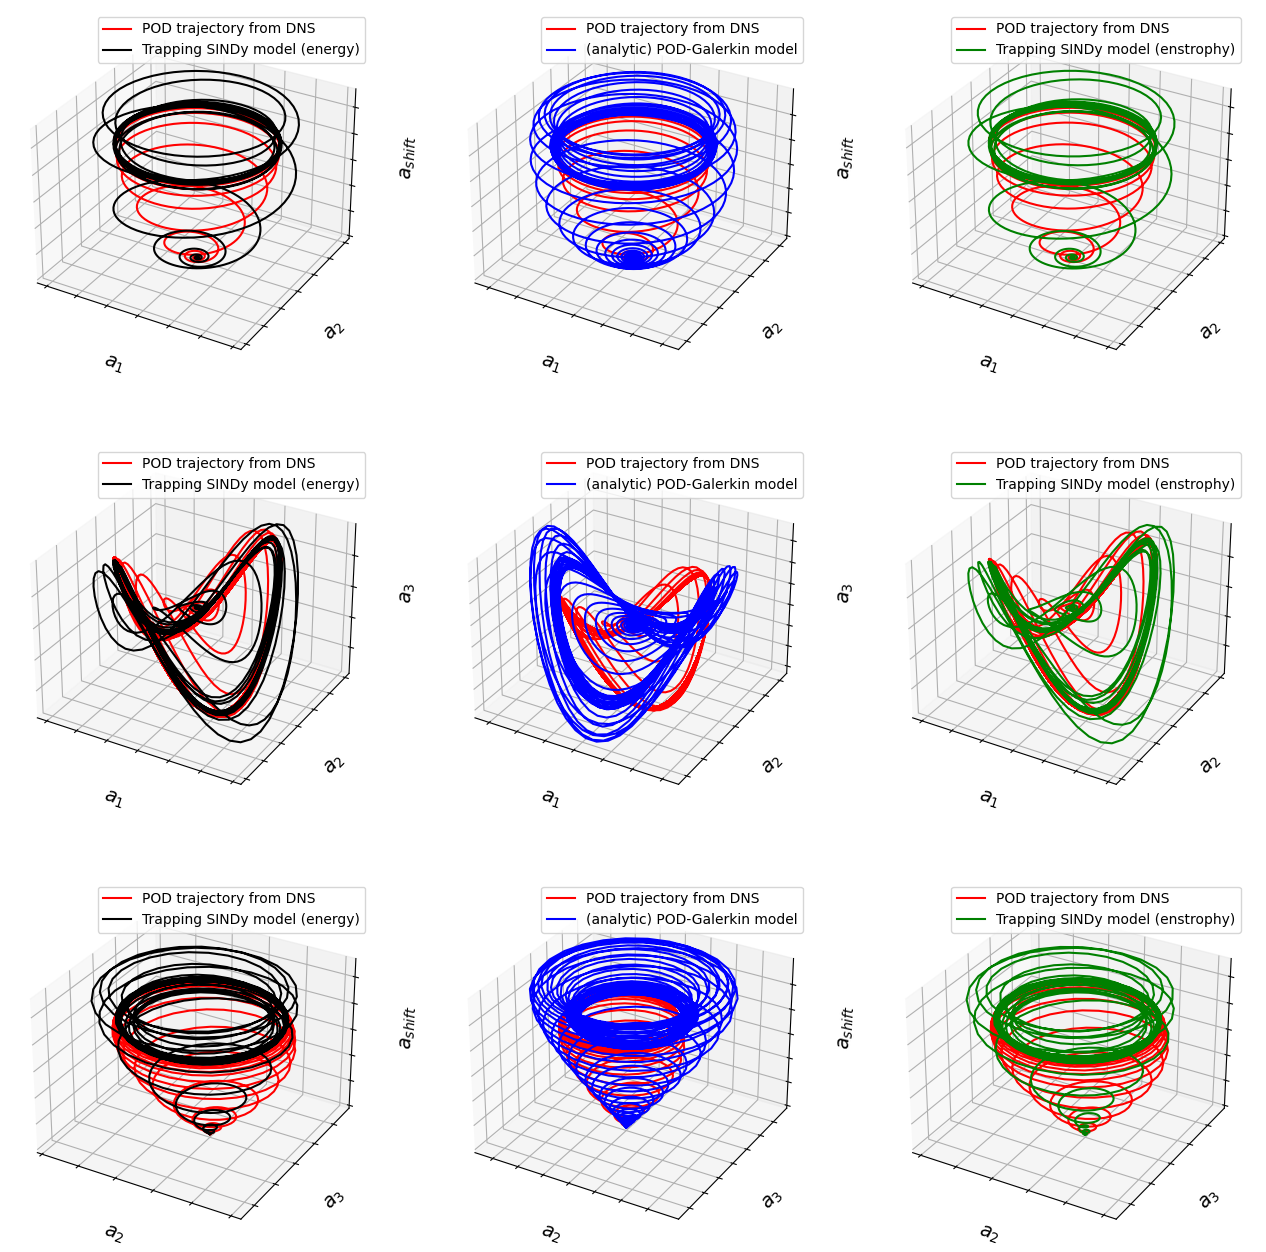

In [11]:
# Interpolate onto better time base
t_traj = np.linspace(t[0], t[-1], len(t) * 1)

# simulate trapping SINDy results
xtraj_energy = energy_model.simulate(a0, t_traj)
xtraj_enstrophy = enstrophy_model.simulate(a0, t_traj)

# simulate and plot 5D von Karman trajectory results
t_span = (t_traj[0], t_traj[-1])
xtraj_pod9 = solve_ivp(model5, t_span, a0, t_eval=t_traj, 
                       **integrator_keywords).y.T

# Make awesome plot
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(16, 16))
data = [a[:, [0, 1, -1]], xtraj_energy[:, [0, 1, -1]], 
        a[:, [0, 1, -1]], xtraj_pod9[:, [0, 1, -1]], 
        a[:, [0, 1, -1]], xtraj_enstrophy[:, [0, 1, -1]],
        a[:, [0, 1, 2]], xtraj_energy[:, [0, 1, 2]], 
        a[:, [0, 1, 2]], xtraj_pod9[:, [0, 1, 2]], 
        a[:, [0, 1, 2]], xtraj_enstrophy[:, [0, 1, 2]], 
        a[:, [2, 3, -1]], xtraj_energy[:, [2, 3, -1]], 
        a[:, [2, 3, -1]], xtraj_pod9[:, [2, 3, -1]],
        a[:, [2, 3, -1]], xtraj_enstrophy[:, [2, 3, -1]]]
data_labels = [[r'$a_1$', r'$a_2$', r'$a_{shift}$'], 
               [r'$a_1$', r'$a_2$', r'$a_3$'], 
               [r'$a_2$', r'$a_3$', r'$a_{shift}$']]
for i in range(3):
    ax[i, 0].plot(data[6 * i][:, 0], data[6 * i][:, 1], data[6 * i][:, 2], 
                  color='r', label='POD trajectory from DNS')
    ax[i, 0].plot(data[6 * i + 1][:, 0], data[6 * i + 1][:, 1], 
                  data[6 * i + 1][:, 2],
                  color='k', label='Trapping SINDy model (energy)')
    ax[i, 1].plot(data[6 * i + 2][:, 0], data[6 * i + 2][:, 1], 
                  data[6 * i + 2][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 1].plot(data[6 * i + 3][:, 0], data[6 * i + 3][:, 1], 
                  data[6 * i + 3][:, 2],
                  color='b', label='(analytic) POD-Galerkin model')
    ax[i, 2].plot(data[6 * i + 4][:, 0], data[6 * i + 4][:, 1], 
                  data[6 * i + 4][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 2].plot(data[6 * i + 5][:, 0], data[6 * i + 5][:, 1], 
                  data[6 * i + 5][:, 2],
                  color='g', label='Trapping SINDy model (enstrophy)')
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_zticklabels([])
    ax[i, 0].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 0].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 0].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 1].legend(fontsize=10)
    ax[i, 1].set_xticklabels([])
    ax[i, 1].set_yticklabels([])
    ax[i, 1].set_zticklabels([])
    ax[i, 1].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 1].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 1].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 2].legend(fontsize=10)
    ax[i, 2].set_xticklabels([])
    ax[i, 2].set_yticklabels([])
    ax[i, 2].set_zticklabels([])
    ax[i, 2].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 2].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 2].set_zlabel(data_labels[i][2], fontsize=14)
plt.show()

In [23]:
max_iter = 5000
eta = 1.0e4
threshold = 0
alpha_m = 1e-1 * eta
alpha = 1e10
beta = 1e-12


mod_matrix = enstrophy_integrals[1:, 1:]
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    mod_matrix=mod_matrix,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library_no_bias,
)
model.fit(a, t=t)
Xi = model.coefficients().T
Lenstrophy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenstrophy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val, mod_matrix)

check_local_stability(r, Xi, sindy_opt, mean_val, mod_matrix)
enstrophy_model = model
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q = np.tensordot(mod_matrix, Q, axes=([1], [0]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Maximum deviation from the constraints = ', Q_sum)
rhos_minus, rhos_plus = make_trap_progress_plots(r, sindy_opt, mod_matrix)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.402e-01 ... 1.362e-03 ... 0.00e+00 ... 5.52e-10 ... 1.40e-12 ... 8.42e-01


LinAlgError: 79-th leading minor of the array is not positive definite

In [ ]:
make_progress_plots(r, sindy_opt)

In [ ]:
# Interpolate onto better time base
fs = 18
t_traj = np.linspace(t[0], t[-1], len(t) * 2)
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(16, 16))
a0s = [(np.random.rand(5) - 0.5) * 20 for i in range(2)]
for a0 in a0s:
    print(a0)

    # simulate trapping SINDy results
    xtraj_energy = energy_model.simulate(a0, t_traj)
    xtraj_enstrophy = enstrophy_model.simulate(a0, t_traj)

    # simulate and plot 5D von Karman trajectory results
    t_span = (t_traj[0], t_traj[-1])
    xtraj_pod9 = solve_ivp(model5, t_span, a0, t_eval=t_traj, 
                           **integrator_keywords).y.T

    # Make awesome plot
    data = [a[:, [0, 1, -1]], xtraj_energy[:, [0, 1, -1]], 
            a[:, [0, 1, -1]], xtraj_pod9[:, [0, 1, -1]], 
            a[:, [0, 1, -1]], xtraj_enstrophy[:, [0, 1, -1]],
            a[:, [0, 1, 2]], xtraj_energy[:, [0, 1, 2]], 
            a[:, [0, 1, 2]], xtraj_pod9[:, [0, 1, 2]], 
            a[:, [0, 1, 2]], xtraj_enstrophy[:, [0, 1, 2]], 
            a[:, [2, 3, -1]], xtraj_energy[:, [2, 3, -1]], 
            a[:, [2, 3, -1]], xtraj_pod9[:, [2, 3, -1]],
            a[:, [2, 3, -1]], xtraj_enstrophy[:, [2, 3, -1]]]
    data_labels = [[r'$a_1$', r'$a_2$', r'$a_{shift}$'], 
                   [r'$a_1$', r'$a_2$', r'$a_3$'], 
                   [r'$a_2$', r'$a_3$', r'$a_{shift}$']]
    ax[0, 0].set_title('Global Trapping SINDy, energy', fontsize=22)
    ax[0, 1].set_title('POD-Galerkin model', fontsize=22)
    ax[0, 2].set_title('Local Trapping SINDy, enstrophy', fontsize=22)
    for i in range(3):
        ax[i, 0].plot(data[6 * i][:, 0], data[6 * i][:, 1], data[6 * i][:, 2], 
                      'k--', label='POD trajectory from DNS')
        ax[i, 0].plot(data[6 * i + 1][:, 0], data[6 * i + 1][:, 1], 
                      data[6 * i + 1][:, 2], linestyle='--',
                      label='Trapping SINDy model (energy)')
        ax[i, 1].plot(data[6 * i + 2][:, 0], data[6 * i + 2][:, 1], 
                      data[6 * i + 2][:, 2],
                      'k--', label='POD trajectory from DNS')
        ax[i, 1].plot(data[6 * i + 3][:, 0], data[6 * i + 3][:, 1], 
                      data[6 * i + 3][:, 2], linestyle='--',
                      label='(analytic) POD-Galerkin model')
        ax[i, 2].plot(data[6 * i + 4][:, 0], data[6 * i + 4][:, 1], 
                      data[6 * i + 4][:, 2],
                      'k--', label='POD trajectory from DNS')
        ax[i, 2].plot(data[6 * i + 5][:, 0], data[6 * i + 5][:, 1], 
                      data[6 * i + 5][:, 2], linestyle='--',
                      label='Trapping SINDy model (enstrophy)')
        if i == 2:
            xlim = 1
            ylim = 1
        else: 
            xlim = 2
            ylim = 2
        if i == 1:
            zlim = 0.5
            zlim_minus = -0.5
        else:
            zlim = 2.5
            zlim_minus = 0
        #ax[i, 0].legend(fontsize=10)
        ax[i, 0].set_xticklabels([])
        ax[i, 0].set_yticklabels([])
        ax[i, 0].set_zticklabels([])
        ax[i, 0].set_xlabel(data_labels[i][0], fontsize=fs)
        ax[i, 0].set_ylabel(data_labels[i][1], fontsize=fs)
        ax[i, 0].set_zlabel(data_labels[i][2], fontsize=fs)
        ax[i, 0].set_xlim(-xlim, xlim)
        ax[i, 0].set_ylim(-ylim, ylim)
        ax[i, 0].set_zlim(zlim_minus, zlim)
        #ax[i, 1].legend(fontsize=10)
        ax[i, 1].set_xticklabels([])
        ax[i, 1].set_yticklabels([])
        ax[i, 1].set_zticklabels([])
        ax[i, 1].set_xlabel(data_labels[i][0], fontsize=fs)
        ax[i, 1].set_ylabel(data_labels[i][1], fontsize=fs)
        ax[i, 1].set_zlabel(data_labels[i][2], fontsize=fs)
        ax[i, 1].set_xlim(-xlim, xlim)
        ax[i, 1].set_ylim(-ylim, ylim)
        ax[i, 1].set_zlim(zlim_minus, zlim)
        #ax[i, 2].legend(fontsize=10)
        ax[i, 2].set_xticklabels([])
        ax[i, 2].set_yticklabels([])
        ax[i, 2].set_zticklabels([])
        ax[i, 2].set_xlabel(data_labels[i][0], fontsize=fs)
        ax[i, 2].set_ylabel(data_labels[i][1], fontsize=fs)
        ax[i, 2].set_zlabel(data_labels[i][2], fontsize=fs)
        ax[i, 2].set_xlim(-xlim, xlim)
        ax[i, 2].set_ylim(-ylim, ylim)
        ax[i, 2].set_zlim(zlim_minus, zlim)
plt.savefig('enstrophy_results.pdf')

In [ ]:
# define energies of the DNS, and both the 5D and 9D models 
# for POD-Galerkin and the trapping SINDy models
E = np.sum(a ** 2, axis=1)
E_galerkin5 = np.sum(xtraj_pod9 ** 2, axis=1)
E_sindy5 = np.sum(xtraj_energy ** 2, axis=1)
E_sindy5_local = np.sum(xtraj_enstrophy ** 2, axis=1)

# plot the energies
plt.figure(figsize=(16, 4))
plt.plot(t, E, 'r', label='DNS')
plt.plot(t_traj, E_galerkin5, 'm', label='POD-5')
plt.plot(t_traj, E_sindy5, 'k', label=r'SINDy-energy')
plt.plot(t_traj, E_sindy5_local, 'b', label=r'SINDy-enstrophy')

# do some formatting and save
plt.legend(fontsize=22, loc=2)
plt.grid()
plt.xlim([0, 300])
plt.ylim(0, 20)
ax = plt.gca()
ax.set_yticks([0, 10, 20])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel('Total energy', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.show()

# 